# Multi-Input Neural Network 

In this notebook we will experiment with neural networks that can handle multiple types of input data. We will use TensorFlow and Keras to build a model that takes both numerical and image data as inputs.

## Neural Network Archetecture

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

### Preliminary Work

The keras functional API allows us to create complex models with multiple inputs and outputs. We will use this API to create a model that takes both numerical and image data as inputs. We will start by defining the input layers for both types of data. The image input will be processed through a convolutional neural network (CNN) to extract features, while the numerical input will be processed through a dense layer. Finally, we will concatenate the outputs of both branches and pass them through additional dense layers to make the final prediction.

We can think of each of these branches as separate neural networks that are trained together to make a final prediction. The image branch will learn to extract features from the images, while the numerical branch will learn to extract features from the numerical data. By combining these features, we can create a more powerful model that can make better predictions.

Starting with the image branch, we will use a simple CNN architecture that consists of several convolutional layers followed by max pooling layers. The output of the CNN will be flattened and passed through a dense layer to create a feature vector that can be concatenated with the numerical features.

In [25]:
IMAGE_SHAPE = (432,288,3)

In [ ]:
image_input = Input(shape=IMAGE_SHAPE, name="image_input")
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

Next, we will define the numerical branch of the model. This branch will mimic a multilayer perceptron (MLP) architecture that consists of several dense layers with ReLU activation functions. The output of the numerical branch will also be a feature vector that can be concatenated with the image features.

In [26]:
FEATURE_SHAPE = (57,)

In [ ]:
feat_input = Input(shape=FEATURE_SHAPE, name="librosa_input")
y = layers.Dense(64, activation='relu')(feat_input)
y = layers.Dropout(0.2)(y)
y = layers.Dense(32, activation='relu')(y)

Now that we have the two branches defined, we will concatenate the outputs of both branches and pass them through additional dense layers to make the final prediction. The final layer will use a softmax activation function to output probabilities for each class in our classification problem.

In [ ]:
# --- FUSION: Combine the branches ---
combined = layers.Concatenate()([x, y])

# --- OUTPUT: Final Decision Layers ---
z = layers.Dense(32, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(z) # 10 genres

### Neural Network Generation Method

In [4]:
def create_multimodal_model(img_shape:tuple=(128, 128, 3), feat_shape:tuple=(57,),classes_count:int = 10) ->models.Model:
    
    #Convolutional layer fo the nerual network
    image_input = Input(shape=img_shape, name="image_input")
    x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    
    #Multilayer perceptron layer of the neural network
    feat_input = Input(shape=feat_shape, name="librosa_input")
    y = layers.Dense(64, activation='relu')(feat_input)
    y = layers.Dropout(0.2)(y)
    y = layers.Dense(32, activation='relu')(y)

    #Concatenate the brances of the neural network
    combined = layers.Concatenate()([x, y])
    
    #Final output layer
    z = layers.Dense(32, activation='relu')(combined)
    output = layers.Dense(classes_count, activation='softmax')(z) # 10 genres

    #Create a model from the combined archetecture
    model = models.Model(inputs=[image_input, feat_input], outputs=output)
    return model

## Training Preliminary Work

In [5]:
import os
import numpy as np
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from datetime import datetime as datetime

Now that we have an archetecture defined, we can prepare for training the model. This includes compiling the model with an appropriate loss function and optimizer. These steps are the same as the standard model training process.

Let's start by defining some base paths that we will use for loading and saving data.

In [6]:
BASE_PATH = r"C:\Users\JTWit\Documents\ECE 579\Datasets\Split GTZAN Dataset"
LIBROSA_DATA = r"C:\Users\JTWit\Documents\ECE 579\Datasets\GTZAN Dataset\features_30_sec.csv"
TEST_PATH = os.path.join(BASE_PATH,'test')
TRAIN_PATH = os.path.join(BASE_PATH,'train')

SAVE_PATH = os.path.join(r"C:\Users\JTWit\Documents\ECE 579","Custom DNN Models")

#Make the save path for the neural network just in case it does not yet exist
os.makedirs(SAVE_PATH,exist_ok = True)

checkpoint_dir = os.path.join(r"C:\Users\JTWit\Documents\ECE 579",'Training Checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

### Data Preparation

We are working with the librosa library that gets us additional features from the audio that will be useful for training and will serve as the numerical input vector for our neural network. Let's start by loading a pandas dataframw with the contents of the predefined GTZAN dataset. 

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv(LIBROSA_DATA)

#Add image name column to our dataframe
df['image_name'] = df['filename'].str.replace('.','').str.replace('wav','.png')

The next step is to work with the raw data to create our training data. Let's define the imports required for data preparation and loading. 

In [9]:
import numpy as np
import cv2
import os

Let's write some code that will iterate through a training path and load the images, get the numerical data from our CSV file, and create the appropriate labels for our training data.

In [10]:
images = []
features = []
labels = []

for root, dirs, files in os.walk(TRAIN_PATH):
    for file in files:
        
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path)
        
        if img is None: continue
        img = cv2.resize(img, (128, 128)) 

        feat = df.loc[df['image_name'] == file].values.reshape(-1)[2:59]
        
        if len(feat) > 0:
            images.append(img)
            features.append(feat.astype(np.float32))
            labels.append(os.path.basename(root)) 

Now that we have a working code block let's convert it to a function that we can call to load our data.

In [ ]:
def load_multimodal_data(path, df):
    images = []
    features = []
    labels = []
    
    for root, dirs, files in os.walk(path):
        for file in files:
            # 1. Load Image
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.resize(img, (128, 128)) # Resize for consistency
            
            # 2. Get Numerical Data
            # Match the image name to the CSV
            feat = df.loc[df['image_name'] == file].values.reshape(-1)[2:59]
            
            if len(feat) > 0:
                images.append(img)
                features.append(feat.astype(np.float32))
                labels.append(os.path.basename(root)) # Folder name as label

    return np.array(images), np.array(features), np.array(labels)

In [12]:
X_img_train, X_feat_train, y_train = load_multimodal_data(TRAIN_PATH, df)

Now that we have properly loaded our dataset we can create labels for our training data. We will use the directory structure of the dataset to create labels for our data.

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

We will create the scalar and the label encoder for our training data. The scalar will be used to normalize our numerical data, while the label encoder will be used to convert our labels into a format that can be used for training.

In [ ]:
le = LabelEncoder()
scaler = StandardScaler()

Next, we will shuffle our training data so it is not in any particular order. This is important for training our model effectively. We will use the `shuffle` function from the `sklearn.utils` module to shuffle our data.

In [ ]:
y_train_encoded = le.fit_transform(y_train)
X_feat_train_scaled = scaler.fit_transform(X_feat_train)

X_img_train_norm = X_img_train.astype('float32') / 255.0


In [46]:
# Shuffle all arrays together so the indices still match
X_img_train, X_feat_train, y_train_encoded = shuffle(
    X_img_train_norm, X_feat_train_scaled, y_train_encoded, random_state=42
)

### Model Compilation and Training Callbacks

Next, we will compile the model. We will use the adam optimizer and use sparse categorical crossentropy as our loss function since we are working with a multi-class classification problem. We will also set up some callbacks to help with training, such as early stopping and model checkpointing.

In [36]:
from tensorflow.keras.optimizers import Adam

In [42]:
LEARNING_RATE = 1e-3

In [40]:
model = create_multimodal_model()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

We can print a summary of our model to see the architecture and the number of parameters in each layer.

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ librosa_input       │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      3,712 │ librosa_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │  3,686,464 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      3,104 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │        330 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,715,082 (14.17 MB)

 Trainable params: 3,715,082 (14.17 MB)

 Non-trainable params: 0 (0.00 B)

We can also add some optimizers and metrics to monitor during training. We will define a learning rate scheduler to adjust the learning rate during training, and we will also set up a model checkpoint to save the best model during training.

We will also show how to use the model checkpoint to save the best model during training and how to load the best model after training is complete. 

In [34]:
# Updated Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,      
    patience=5,      
    min_lr=1e-6,     
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    mode="max", 
    patience=10,     
    restore_best_weights=True 
)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,  
    monitor='val_loss',      
    save_best_only=False,    
    verbose=1                
)


callbacks = [reduce_lr,earlystop] 

## Training the Model

We are finally in a place to train our model. We will use the fit method to train our model on the training data and validate it on the validation data. We will also use the callbacks that we defined earlier to monitor the training process and save the best model.

In [17]:
from datetime import datetime as dt
import matplotlib.pyplot as plt

Let's do a sanity check on our training data to make sure everything is in order before we start training. We can check the shapes of our training data and labels to ensure they are compatible with our model.

If this cell is working correctly, we should see the shapes of our training data and labels printed out without any errors. This will confirm that our data is properly loaded and ready for training.

(799, 128, 128, 3)
(799, 57)
(799,)
Librosa Extracted Features[-0.4725753   1.0953289  -0.5240801  -0.19680017 -0.9239613  -0.25470012
 -0.37295708  0.7631113  -0.6339493   0.7867901  -1.1260484  -0.5212917
  0.3438448  -0.62959486  0.19699778 -0.40166855 -1.829801   -0.6104647
  1.377474    0.7654688  -0.3748603   0.8310754   0.31424665 -0.01707981
  0.3334708   0.30639008  0.9897268   0.6115183   0.41208875 -0.36588976
  1.4305      1.305249    1.3208866  -0.36914608  1.8857079   0.54763925
  0.6122099   0.06260236  0.73993015  0.17227991  0.835517    0.40508983
 -0.0812313   0.5228857   0.23687308 -0.46244988 -0.28783333 -0.02164751
 -0.14806405  0.7051139  -0.06266584 -0.02338441 -0.4352256   0.554819
 -0.39028132  0.46828243 -0.51617813]
Encoded Label: 0


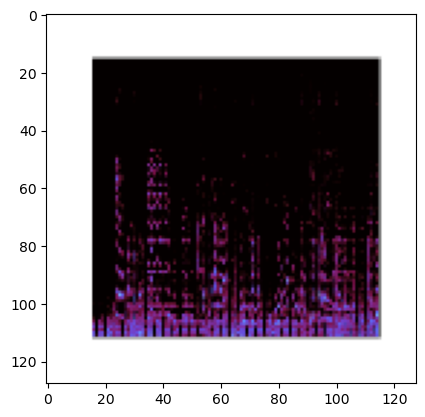

In [18]:
print(X_img_train_norm.shape)
print(X_feat_train_scaled.shape)
print(y_train_encoded.shape)

plt.figure()
plt.imshow(X_img_train[0])

print(f"Librosa Extracted Features{X_feat_train_scaled[0]}")
print(f"Encoded Label: {y_train_encoded[0]}")

The final step before training is to define the batch size and the number of epochs for training. We will also specify the validation data that we will use to monitor the training process.

In [19]:
BATCH_SIZE = 32
EPOCHS = 50
VAL_SPLIT = 0.2
NETWORK_NAME = 'Multiple Input Neural Network'

In [ ]:
# Train the model
history = model.fit(
    x=[X_img_train, X_feat_train], 
    y=y_train_encoded,
    validation_split=VAL_SPLIT, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

accuracy = history.history['accuracy'][-1]
date_str = dt.today().strftime('%Y-%m-%d')
name_string = f"{NETWORK_NAME}(accuracy = {accuracy:.4f})(date = {date_str}).keras"

save_file = os.path.join(SAVE_PATH,name_string)

# Save the model
model.save(save_file)

## Evaluating the Model

Just like we did with the training data, we can also prepare our test data and evaluate the model on the test set to see how well it performs on unseen data.

In [27]:
X_img_test, X_feat_test, y_test = load_multimodal_data(TEST_PATH, df)

y_test_encoded = le.fit_transform(y_test)
X_feat_test_scaled = scaler.fit_transform(X_feat_test)

X_img_test_norm = X_img_test.astype('float32') / 255.0

Once we prepare the testing data, we can use the evaluate method to get the loss and accuracy of our model on the test set. This will give us an idea of how well our model generalizes to new data.

In [30]:
predictions = model.predict(x=[X_img_test_norm, X_feat_test_scaled])

predicted_classes = np.argmax(predictions, axis=1)

results = model.evaluate(
    x=[X_img_test_norm, X_feat_test_scaled], 
    y=y_test_encoded
)

print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4400 - loss: 3.4804
Test Loss: 3.480449914932251
Test Accuracy: 44.00%


### Confusion Matrix

Another helpful tool for evaluating the performance of a classification model is the confusion matrix. A confusion matrix is a table that is used to evaluate the performance of a classification model by comparing the predicted labels with the true labels. It provides a summary of the number of true positives, true negatives, false positives, and false negatives.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

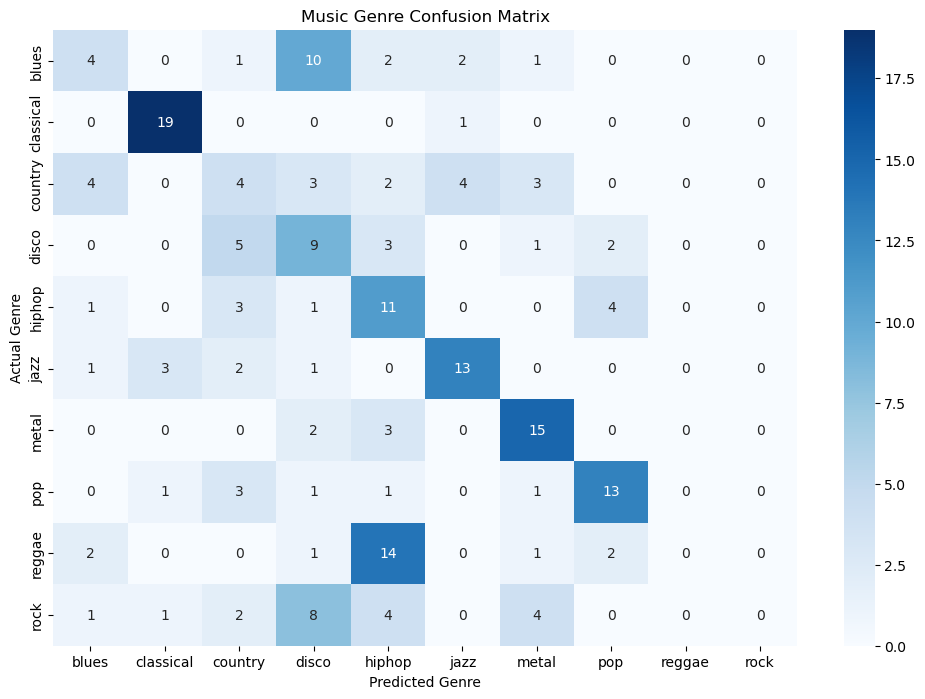

In [31]:
cm = confusion_matrix(y_test_encoded, predicted_classes)

genre_names = le.classes_

plt.figure(figsize=(12, 8))
sns.heatmap(
    cm, 
    annot=True,              
    fmt='d',                 
    cmap='Blues',            
    xticklabels=genre_names, 
    yticklabels=genre_names
)

plt.title('Music Genre Confusion Matrix')
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.show()

## Saving Model for Future Use

In [ ]:
import pickle
import tensorflow as tf
import pickle
import numpy as np
import cv2
import os

In [ ]:
#Specify the base directory for saving neural network models in the compressed pickle format
PICKLE_DUMP_DIR = os.path.join(r"C:\Users\JTWit\Documents\ECE 579","Pickle DUMPS")

#Create a save name for the nerual network that we would like to save
PICKLE_DUMP_PATH = os.path.join(PICKLE_DUMP_DIR,NETWORK_NAME)

#Make the dump dir if it has not been made already
os.makedirs(PICKLE_DUMP_DIR,exist_ok=True)

In [ ]:
#Save the Model
model.save(PICKLE_DUMP_PATH)

# Save the Scaler (X_feat_train_scaled)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the LabelEncoder (le)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("All components saved successfully!")

### Loading model from pickle file

In [ ]:
# Load the components
model = tf.keras.models.load_model('music_genre_model.keras')

with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    loaded_le = pickle.load(f)

# Preprocess a new single sample
new_img_reshaped = cv2.resize(new_img, (128, 128)) / 255.0
new_img_reshaped = np.expand_dims(new_img_reshaped, axis=0) # Add batch dimension

new_feat_scaled = loaded_scaler.transform(new_feat.reshape(1, -1))

# Predict
preds = model.predict([new_img_reshaped, new_feat_scaled])
class_idx = np.argmax(preds)
genre_name = loaded_le.inverse_transform([class_idx])[0]

print(f"The model identifies this as: {genre_name}")

## Object Oriented Implementation

In [ ]:
#Helper Imports
import os
import pandas as pd
import pickle
import numpy as np
import cv2
from datetime import datetime as dt

#Sklearn Imports For Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle

#Tensorflow and Keras Imports
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, Input

#Performance Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


import warnings


class BimodalNN:
    #=================================================
    # Initialization Method
    #=================================================
    def __init__(self,BASE_PATH:str,  LIBROSA_PATH:str, TEST_DIR:str = 'test', TRAIN_DIR:str = 'train',SAVE_DIR:str = 'bimodal save'):
        
        #Make Dirs
        self.BASE_PATH = BASE_PATH
        self.TRAIN_PATH = os.path.join(self.BASE_PATH,TRAIN_DIR)
        self.TEST_PATH = os.path.join(self.BASE_PATH,TEST_DIR)
        self.SAVE_DIR = SAVE_DIR

        #Make sure the save dir exists
        os.makedirs(self.SAVE_DIR,exist_ok=True)

        #Create checkpoint dirs
        checkpoint_dir = os.path.join(r"C:\Users\JTWit\Documents\ECE 579",'Training Checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

        # Create the directory if it doesn't exist
        os.makedirs(checkpoint_dir, exist_ok=True)

        #Configure Variables
        self.model = None
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        

        #Save path to the librosa dataset 
        self.LIBROSA_PATH = LIBROSA_PATH 
        self.__read_librosa()

    
    #=================================================
    # Network Model Configuration
    #=================================================
    def __get_default_model(self,img_shape:tuple = (128,128,3), feat_shape:tuple = (57,), classes_count:int = 10)->None:
        
        #Convolutional layer fo the nerual network
        image_input = Input(shape=img_shape, name="image_input")

        x = layers.Conv2D(16, (3, 3), activation='relu')(image_input)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(32, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)

        x = layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)


        x = layers.Flatten()(x)

        x = layers.Dense(32, activation='relu')(x)
        
        #Multilayer perceptron layer of the neural network
        feat_input = Input(shape=feat_shape, name="librosa_input")
        
        y = layers.Dense(64, activation='relu')(feat_input)
        y = layers.Dropout(0.2)(y)

        y = layers.Dense(32, activation='relu')(y)
        y = layers.Dropout(0.4)(y)

        y = layers.Dense(16, activation='relu')(y)

        #Concatenate the brances of the neural network
        combined = layers.Concatenate()([x, y])
        
        #Final output layer
        z = layers.Dense(64, activation='relu')(combined)
        output = layers.Dense(classes_count, activation='softmax')(z) # 10 genres

        #Create a model from the combined archetecture
        self.model = models.Model(inputs=[image_input, feat_input], outputs=output)
        
    def load_model(self,model)->None:
        self.model = model

    def load_from_path(self, path:str)->None:
        pass

    #=================================================
    # Prepare Data
    #=================================================
    def __prepare_data(self,dir:str):
        images = []
        features = []
        labels = []
        
        for root, dirs, files in os.walk(dir):
            for file in files:
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.resize(img, (128, 128)) # Resize for consistency
    
                feat = self.df.loc[self.df['image_file'] == file].values.reshape(-1)[4:61]
                
                if len(feat) > 0:
                    images.append(img)
                    features.append(feat.astype(np.float32))
                    labels.append(os.path.basename(root)) # Folder name as label

        return np.array(images), np.array(features), np.array(labels)


    def __normalize_data(self,X_img,X_feat,y ):
        y_encoded = self.le.fit_transform(y)
        X_feat_scaled = self.scaler.fit_transform(X_feat)

        X_img_norm = X_img.astype('float32') / 255.0

        return X_img_norm,X_feat_scaled,y_encoded

    def __read_librosa(self):
        self.df = pd.read_csv(self.LIBROSA_PATH)
        
    #=================================================
    # Train Neural Network
    #=================================================
    def train(self,model_name:str, EPOCHS:int = 50,LEARNING_RATE:float = 1e-3, VAL_SPLIT:float = 0.2,BATCH_SIZE:int = 16, callbacks:list = []):

        #Check to see if the model has been defined for this instance of the object
        if not self.model:
            warnings.warn("Custom model has not been loaded. Defaulting to predefined model.", UserWarning)
            self.__get_default_model()
        
        #Compile the model
        self.model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
        
        #Prepare the training data
        X_img_train, X_feat_train, y_train = self.__prepare_data(self.TRAIN_PATH)
        X_img_train_norm,  X_feat_train_scaled ,y_train_encoded = self.__normalize_data(X_img_train, X_feat_train, y_train)

        X_img_train, X_feat_train, y_train_encoded = shuffle(
            X_img_train_norm, 
            X_feat_train_scaled, 
            y_train_encoded, 
            random_state=42)   

        #Configure default callbacks if none are specified
        if not callbacks:
            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,      
                patience=5,      
                min_lr=1e-6,     
                verbose=1
            )

            earlystop = EarlyStopping(
                monitor='val_accuracy',
                mode="max", 
                patience=10,     
                restore_best_weights=True 
            )

            checkpoint = ModelCheckpoint(
                filepath=self.checkpoint_prefix,
                save_weights_only=True,  
                monitor='val_loss',      
                save_best_only=False,    
                verbose=1                
            )

            callbacks = [reduce_lr,earlystop] 

        #Train the neural network model
        history = self.model.fit(
            x=[X_img_train,X_feat_train], 
            y=y_train_encoded,
            validation_split=VAL_SPLIT, 
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks
        )

        #Keep track of the training and acccuracy of the model and create the name string        
        train_accuracy = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        date_str = dt.today().strftime('%Y-%m-%d')
        name_string = f"{model_name}(train accuracy = {train_accuracy:.4f}) (val accuracy = {val_acc:.4f})(date = {date_str}).keras"

        save_file = os.path.join(self.SAVE_DIR,name_string)

        # Save the model
        self.model.save(save_file)


    #=================================================
    # Saving and Loading pickle 
    #=================================================
    def pickle_compress(self,network_path:str, pickle_path:str)->None:
        
        if self.model is not None:
            self.model.save(network_path)

            # Save the Scaler (X_feat_train_scaled)
            with open('scaler.pkl', 'wb') as f:
                pickle.dump(self.scaler, f)

            # Save the LabelEncoder (le)
            with open('label_encoder.pkl', 'wb') as f:
                pickle.dump(self.le, f)

            print("All components saved successfully!")

        else:
            raise Exception("No neural network loaded to export. Load a neural network using one of the load methods")

    def set_from_pickle(self,network_path:str, pickle_path:str)->None:

        if os.path.exists(network_path):
            # Load the components
            self.model = tf.keras.models.load_model(network_path)
        else:
            raise Exception("File path specified does not exist. Verify that the path provided links to a pickle export")

        if os.path.exists(pickle_path):
            with open('scaler.pkl', 'rb') as f:
                self.scaler = pickle.load(f)

            with open('label_encoder.pkl', 'rb') as f:
                self.le = pickle.load(f)
        else:
            raise Exception("File path specified does not exist. Verify that the path provided links to a pickle export")


    #=================================================
    # Make predictions with the neural network
    #=================================================
    def predict(self,image_path:str, librosa_features)->tuple:
        raise NotImplementedError("Not implemented just yet")


    #=================================================
    # Evaluate Neural Network
    #=================================================
    def evaluate(self, test_path:str = "", verbose:bool = True):

        if self.model is not None:
            
            #Check to see if a unique test patch has been specified
            if test_path:
                X_img_test, X_feat_test, y_test = self.__prepare_data(test_path)
            
            #Use the default test set 
            else:
                X_img_test, X_feat_test, y_test = self.__prepare_data(self.TEST_PATH)
            
            #Normalize the images using the scalar and the label encoder
            X_img_test_norm, X_feat_test_scaled, y_test_encoded = self.__normalize_data(X_img_test, X_feat_test, y_test)

            #Make predictions
            predictions = self.model.predict(x=[X_img_test_norm, X_feat_test_scaled])

            #Extract the predicted class labels 
            predicted_classes = np.argmax(predictions, axis=1)

            results = self.model.evaluate(
                x=[X_img_test_norm, X_feat_test_scaled], 
                y=y_test_encoded
            )
            if verbose:
                print(f"Test Loss: {results[0]}")
                print(f"Test Accuracy: {results[1] * 100:.2f}%")

            return y_test_encoded,predicted_classes
        else:
            raise Exception("Error. No model loaded. Please call a load model method to evaluate your model")


    def confusion_matrix(self, title:str = 'Music Genre Confusion Matrix')->None:
        
        y_test_encoded,predicted_classes = self.evaluate(verbose=False)

        cm = confusion_matrix(y_test_encoded, predicted_classes)

        genre_names = self.le.classes_

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            cm, 
            annot=True,              
            fmt='d',                 
            cmap='Blues',            
            xticklabels=genre_names, 
            yticklabels=genre_names
        )

        plt.title(title)
        plt.ylabel('Actual Genre')
        plt.xlabel('Predicted Genre')
        plt.show()
